In [12]:
# Transfer Learning on VGG 16

import warnings
warnings.simplefilter('ignore')

In [13]:
from vgg_transfer import *
from vgg_transfer import VGG_Transfer

In [14]:
# Training parameter
num_epochs = 3          
batch_size = 16          
seed = np.random.seed(123) 

In [15]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: 
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [16]:
class channel_copy(object):
    def __call__(self, img):
        return torch.cat([img, img, img], 0)
    
transform = transforms.Compose([transforms.Resize(512), transforms.ToTensor(), channel_copy()])
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform = transform, 
                                                             p_val = 0.1, p_test = 0.2,
                                                             shuffle = True, show_sample = False, 
                                                             extras = extras)

In [17]:
model = torchvision.models.vgg16(pretrained = True)
#vgg_transfer = VGG_Transfer(n_class = 14, finetuning = False)

In [18]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [20]:
# Customized last layer
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 14))

In [21]:
from loss import *  

model = model.to(computing_device)
criterion = weighted_focal_loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [23]:
# Dropout layer parameter tuning

losses = []
for dropout_rate in [0.40, 0.55, 0.7, 0.85]:
    print("\nDropout Rate: ", dropout_rate)
    model = torchvision.models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    n_inputs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(dropout_rate),
                      nn.Linear(256, 14))
    model = model.to(computing_device)
    
    total_loss = []
    avg_minibatch_loss = []
    epochs = 2
    for epoch in range(epochs):
        N = 25
        N_minibatch_loss = 0.0 
        for minibatch_count, (images, labels) in enumerate(val_loader, 0):

            images, labels = images.to(computing_device), labels.to(computing_device)
            optimizer.zero_grad()
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backprop
            optimizer.step() # weight update

            total_loss.append(loss.item())
            N_minibatch_loss += loss

            if (minibatch_count + 1) % N == 0:      
                N_minibatch_loss /= N
                print('Epoch: %d ! Average minibatch %d loss: %.3f' %
                    (epoch + 1, minibatch_count + 1, N_minibatch_loss))
                avg_minibatch_loss.append(N_minibatch_loss)
                N_minibatch_loss = 0.0

    losses.append(avg_minibatch_loss)


Dropout Rate:  0.4
Epoch: 1 ! Average minibatch 25 loss: 0.699
Epoch: 1 ! Average minibatch 50 loss: 0.697
Epoch: 1 ! Average minibatch 75 loss: 0.699
Epoch: 1 ! Average minibatch 100 loss: 0.699
Epoch: 1 ! Average minibatch 125 loss: 0.697
Epoch: 2 ! Average minibatch 25 loss: 0.699
Epoch: 2 ! Average minibatch 50 loss: 0.698
Epoch: 2 ! Average minibatch 75 loss: 0.699
Epoch: 2 ! Average minibatch 100 loss: 0.699
Epoch: 2 ! Average minibatch 125 loss: 0.697

Dropout Rate:  0.55
Epoch: 1 ! Average minibatch 25 loss: 0.696
Epoch: 1 ! Average minibatch 50 loss: 0.697
Epoch: 1 ! Average minibatch 75 loss: 0.696
Epoch: 1 ! Average minibatch 100 loss: 0.695
Epoch: 1 ! Average minibatch 125 loss: 0.696
Epoch: 2 ! Average minibatch 25 loss: 0.695
Epoch: 2 ! Average minibatch 50 loss: 0.696
Epoch: 2 ! Average minibatch 75 loss: 0.697
Epoch: 2 ! Average minibatch 100 loss: 0.696
Epoch: 2 ! Average minibatch 125 loss: 0.696

Dropout Rate:  0.7
Epoch: 1 ! Average minibatch 25 loss: 0.693
Epoch: 

In [25]:
model = torchvision.models.vgg16(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.7),
                      nn.Linear(256, 14))
model = model.to(computing_device)

In [26]:
# Training with best dropout rate

total_loss = []
avg_minibatch_loss = []

for epoch in range(num_epochs):
    N = 50
    N_minibatch_loss = 0.0 
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):

        images, labels = images.to(computing_device), labels.to(computing_device)
        optimizer.zero_grad()
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backprop
        optimizer.step() # weight update

        total_loss.append(loss.item())
        N_minibatch_loss += loss
        
        if (minibatch_count + 1) % N == 0:      
            N_minibatch_loss /= N
            print('Epoch: %d ! Average minibatch %d loss: %.3f' %
                (epoch + 1, minibatch_count + 1, N_minibatch_loss))
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
print("Training complete after", epoch + 1, "epochs")

Epoch: 1 ! Average minibatch 50 loss: 0.700
Epoch: 1 ! Average minibatch 100 loss: 0.699
Epoch: 1 ! Average minibatch 150 loss: 0.699
Epoch: 1 ! Average minibatch 200 loss: 0.701
Epoch: 1 ! Average minibatch 250 loss: 0.697
Epoch: 1 ! Average minibatch 300 loss: 0.699
Epoch: 1 ! Average minibatch 350 loss: 0.699
Epoch: 1 ! Average minibatch 400 loss: 0.699
Epoch: 1 ! Average minibatch 450 loss: 0.700
Epoch: 1 ! Average minibatch 500 loss: 0.699
Epoch: 1 ! Average minibatch 550 loss: 0.699
Epoch: 1 ! Average minibatch 600 loss: 0.699
Epoch: 1 ! Average minibatch 650 loss: 0.698
Epoch: 1 ! Average minibatch 700 loss: 0.698
Epoch: 1 ! Average minibatch 750 loss: 0.700
Epoch: 1 ! Average minibatch 800 loss: 0.699
Epoch: 1 ! Average minibatch 850 loss: 0.699
Epoch: 1 ! Average minibatch 900 loss: 0.701
Epoch: 1 ! Average minibatch 950 loss: 0.700
Epoch: 1 ! Average minibatch 1000 loss: 0.699
Finished 1 epochs of training
Epoch: 2 ! Average minibatch 50 loss: 0.701
Epoch: 2 ! Average minibat

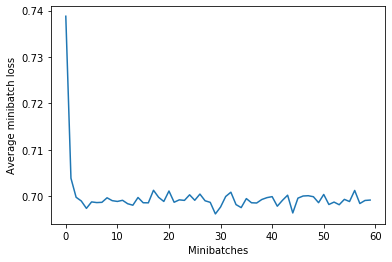

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylabel('Average minibatch loss')
plt.xlabel('Minibatches')
plt.plot(avg_minibatch_loss)
plt.savefig('Plots/vgg_loss.png')
plt.show()

In [36]:
# Testing the model

from test import *
from test import Test_Model

In [37]:
labels_all = []
predictions_all = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(computing_device), labels.to(computing_device)
        labels_all.append(labels)
        output = model(images)
        predictions = output > 0.5
        predictions_all.append(predictions)

labels = torch.cat(labels_all, 0)
predctions = torch.cat(predictions_all, 0)
test_res = Test_Model(predctions.float(), labels)
accuracy = test_res.avg_accuracy().item()
precision = test_res.avg_precision().item()
recall = test_res.avg_recall().item()
BCR = test_res.avg_BCR().item()

In [40]:
print("Test Statistics: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("BCR: ", BCR)

Test Statistics: 
Accuracy:  0.6561
Precision:  0.2828
Recall:  0.4604
BCR:  0.3716
